In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean as cmo
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import linregress

import sys
sys.path.append('../')

from geometry import Geometry
from forcing import Forcing
from layer import LayerModel

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision=2)

np.seterr(all='ignore')
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2

In [9]:
years = np.arange(1979,2017)
x1,x2 = 245.4-360,246.2-360
y1,y2 = -75.13,-74.85

N = 3
ress = ['0.5','1.0','2.0']
tpers = [15,25,25]

cols = ['teal','darkgoldenrod','firebrick']

In [10]:


#MITgcm

ds = xr.open_dataset('../../../data/paulholland/melt.nc')
ds = ds.sel(LONGITUDE=slice(360-114.7,360-109),LATITUDE=slice(-75.3,-74.1))#,TIME=timep)
melt = xr.where(ds.melt==0,np.nan,ds.melt)
melt = melt.mean(dim=['LONGITUDE','LATITUDE'],skipna=True)
MCD = np.zeros(len(years))
for y,yy in enumerate(years):
    MCD[y] = melt.sel(TIME=slice(f"{yy}-1-1",f"{yy}-12-31")).mean()
ds.close()

ds = xr.open_dataset('../../../data/paulholland/melt.nc')
ds = ds.sel(LONGITUDE=slice(360-114.7,360-109),LATITUDE=slice(-75.3+.05,-74.1+.05))#,TIME=timep)
lon = (ds.LONGITUDE - 360.).values
lat = (ds.LATITUDE - .05).values
llon,llat = np.meshgrid(lon,lat)
MKW = np.zeros(len(years))
for y,yy in enumerate(years):
    mmelt = ds.melt.sel(TIME=slice(f"{yy}-1-1",f"{yy}-12-31")).mean(dim='TIME')
    melt = xr.where(mmelt==0,np.nan,mmelt)
    melt = melt.mean(dim=['LONGITUDE','LATITUDE'],skipna=True)
    melt = np.where(llon<x2,melt,np.nan)
    melt = np.where(llat<y2,melt,np.nan)
    MKW[y] = np.nanmean(melt)
ds.close()
    
MCDl = {}
MKWl = {}
for r,res in enumerate(ress):
    MCDl[res] = np.nan*np.zeros(len(years))
    MKWl[res] = np.nan*np.zeros(len(years))
    for y,yy in enumerate(years):
        try:
            ds = xr.open_dataset(f'../../results/CrossDots_{res}_mitgcm_{yy}_{yy}_{tpers[r]:03.0f}.nc')
            MCDl[res][y] = np.nanmean(np.where(ds.tmask==1,ds.melt,np.nan))
            melt = ds.melt.copy()
            melt = xr.where(ds.lon<x2,melt,np.nan)
            melt = xr.where(ds.lat<y2,melt,np.nan)
            MKWl[res][y] = np.nanmean(np.where(ds.tmask==1,melt,np.nan))            
            ds.close()
        except:
            pass

idx = np.argmin((MCD-np.median(MCD))**2)
print(years[idx],MCD[idx],MCDl['2.0'][idx],MCDl['1.0'][idx],MCDl['0.5'][idx])
print(years[idx],MKW[idx],MKWl['2.0'][idx],MKWl['1.0'][idx],MKWl['0.5'][idx])

1983 6.108992715958213 6.575470102626857 6.6015433876102065 nan
1983 6.108992715958213 24.02198980883817 24.41249657890793 nan


In [14]:
for y,yy in enumerate(years):
    print(yy,MCD[y])

1979 7.83443710726867
1980 7.350702507017682
1981 6.272621539904061
1982 5.68283151246839
1983 6.108992715958213
1984 6.968885731551893
1985 8.725988244923721
1986 9.378462696122956
1987 7.233982878979212
1988 6.657551006209555
1989 7.690912394474361
1990 6.40826633779296
1991 4.787529833901919
1992 5.668723282718388
1993 5.44717501842072
1994 4.923641656389206
1995 4.933261603139148
1996 3.584580848597284
1997 3.325819074427825
1998 6.1674069243154435
1999 6.334714970968661
2000 5.3559066213203685
2001 7.591308235693057
2002 6.968185284112516
2003 7.598451800660519
2004 5.158165539295631
2005 4.812418054039485
2006 6.599322737231488
2007 7.73131134352343
2008 5.984506178205329
2009 7.360766599144224
2010 6.3832479608244945
2011 6.032623671837704
2012 5.8090653226769104
2013 4.513502520733733
2014 2.1703316320357384
2015 1.8673393932314892
2016 2.474379701081221


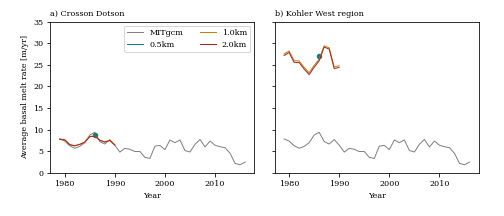

In [11]:
plt.style.use('style_paper')

mpl.rc('figure.subplot',left=.1,right=.95,top=.9,bottom=.2,wspace=.1,hspace=.1)

fig,ax = plt.subplots(1,2,figsize=(7,3),sharey=True)

ax[0].plot(years,MCD,color='.5',label='MITgcm',zorder=0)
ax[1].plot(years,MKW,color='.5',label='MITgcm',zorder=0)

#Layer

for r,res in enumerate(ress):
    if res in ['0.5']:
        ax[0].scatter(years,MCDl[res],20,color=cols[r])
        ax[1].scatter(years,MKWl[res],20,color=cols[r])
    ax[0].plot(years,MCDl[res],c=cols[r],label=f'{res}km',lw=1)
    ax[1].plot(years,MKWl[res],c=cols[r],label=f'{res}km',lw=1)
    
    
ax[0].legend(ncol=2,loc='upper right')
ax[0].set_title('a) Crosson Dotson',loc='left')
ax[0].set_ylabel('Average basal melt rate [m/yr]')

ax[1].set_title('b) Kohler West region',loc='left')

ax[0].set_xlabel('Year')
ax[1].set_xlabel('Year')

ax[0].set_ylim([0,35])
plt.savefig('../../figures/draftplot_timeseries.png',dpi=450)

MITgcm    slope: 1.00 rval: 1.00
Layer 0.5 slope: nan rval: nan
Layer 1.0 slope: nan rval: nan
Layer 2.0 slope: nan rval: nan
-------
MITgcm    slope: 0.79 rval: 0.75
Layer 0.5 slope: nan rval: nan
Layer 1.0 slope: nan rval: nan
Layer 2.0 slope: nan rval: nan


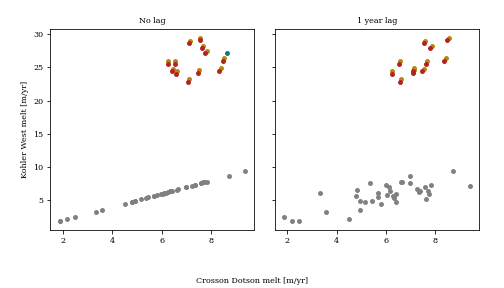

In [5]:
fig,ax = plt.subplots(1,2,figsize=(7,4),sharey=True)

ax[0].scatter(MCD,MKW,15,color='.5')
out = linregress(MCD,MKW)
print(f'MITgcm    slope: {out.slope:.2f} rval: {out.rvalue:.2f}')

for r,res in enumerate(ress):
    ax[0].scatter(MCDl[res],MKWl[res],15,color=cols[r])
    out = linregress(MCDl[res],MKWl[res])
    print(f'Layer {res} slope: {out.slope:.2f} rval: {out.rvalue:.2f}')

print('-------')

ax[1].scatter(MCD[:-1],MKW[1:],15,color='.5')
out = linregress(MCD[:-1],MKW[1:])
print(f'MITgcm    slope: {out.slope:.2f} rval: {out.rvalue:.2f}')

for r,res in enumerate(ress):
    ax[1].scatter(MCDl[res][:-1],MKWl[res][1:],15,color=cols[r])
    out = linregress(MCDl[res][:-1],MKWl[res][1:])
    print(f'Layer {res} slope: {out.slope:.2f} rval: {out.rvalue:.2f}')

ax[0].set_title('No lag')
ax[1].set_title('1 year lag')
ax[0].set_ylabel('Kohler West melt [m/yr]')

fig.supxlabel('Crosson Dotson melt [m/yr]');